In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('paris_temperature.csv')

In [3]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Paris,France",2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,...,3.5,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,"Paris,France",2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,...,4.4,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
2,"Paris,France",2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,...,4.8,4,10,2023-10-03T07:52:29,2023-10-03T19:26:16,0.63,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157..."
3,"Paris,France",2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,...,5.1,4,10,2023-10-04T07:53:57,2023-10-04T19:24:10,0.66,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."
4,"Paris,France",2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,...,3.5,3,10,2023-10-05T07:55:25,2023-10-05T19:22:06,0.70,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

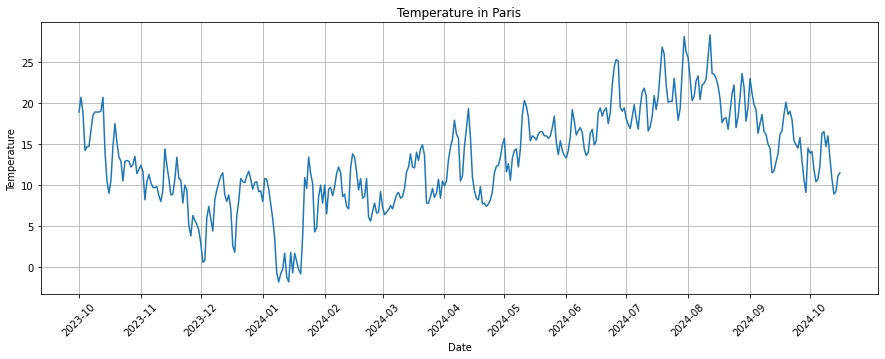

In [5]:
# 1
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.show()

In [6]:
# 3
numerical_features = []
categorical_features = []
date_features = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    elif df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"There are {len(numerical_features)} numerical features: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features: {categorical_features}")

There are 24 numerical features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
There are 8 categorical features: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


In [7]:
df_numerical = df[numerical_features]
df_numerical.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,0.144,100.0,...,11.3,170.2,1023.7,46.5,18.6,39.8,3.5,3,10,0.57
2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,0.000,0.0,...,12.0,173.7,1018.8,48.6,16.8,51.3,4.4,4,10,0.60
2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,0.386,100.0,...,22.8,277.2,1020.5,71.8,22.1,54.5,4.8,4,10,0.63
2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,0.006,100.0,...,12.3,260.9,1029.8,62.0,22.4,58.9,5.1,4,10,0.66
2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,0.014,100.0,...,6.8,238.3,1027.3,82.3,21.3,41.7,3.5,3,10,0.70


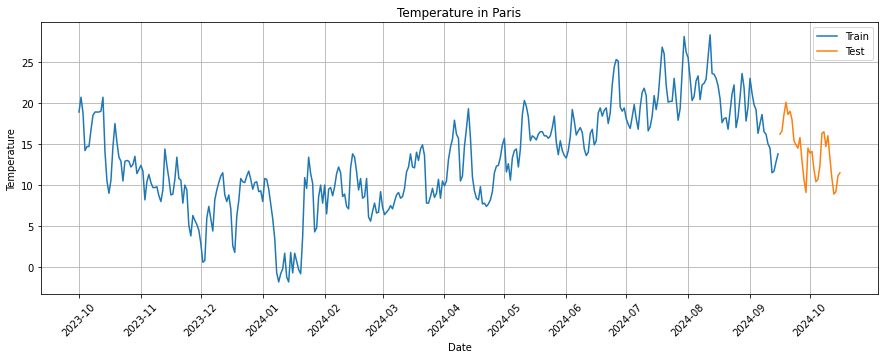

X_train shape: (351, 23), y_train shape: (351,)
X_test shape: (31, 23), y_test shape: (31,)


In [8]:
# # 4
# scaler = MinMaxScaler()
# df_numerical[numerical_features] = scaler.fit_transform(df_numerical[numerical_features])
train_set = df_numerical[df_numerical.index <= pd.Timestamp('2024-09-15')]
test_set = df_numerical[df_numerical.index > pd.Timestamp('2024-09-15')]
plt.figure(figsize=(15, 5))
plt.plot(train_set.index, train_set['temp'], label='Train')
plt.plot(test_set.index, test_set['temp'], label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

X = df_numerical[['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 
                  'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 
                  'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 
                  'uvindex', 'severerisk', 'moonphase']].values

y = df_numerical['temp'].values

train_len = len(train_set)
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Question 7
### (a) Applying LSTM model

In [9]:
def reshape_lstm_input(X, y, n_past):
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1))

    X_reshaped = []
    y_reshaped = []

    for i in range(n_past, len(X)):
        X_reshaped.append(X[i - n_past:i])
        y_reshaped.append(y[i])

    return np.array(X_reshaped), np.array(y_reshaped), scaler_X, scaler_y

n_past = 7
n_features = X_train.shape[1]

X_train_reshaped, y_train_reshaped, scaler_X, scaler_y = reshape_lstm_input(X_train, y_train, n_past)
X_test_reshaped, y_test_reshaped, _, _ = reshape_lstm_input(X_test, y_test, n_past)

if X_train_reshaped is not None and X_test_reshaped is not None:
    print("X_train_reshaped shape:", X_train_reshaped.shape)
    print("y_train_reshaped shape:", y_train_reshaped.shape)
    print("X_test_reshaped shape:", X_test_reshaped.shape)
    print("y_test_reshaped shape:", y_test_reshaped.shape)


X_train_reshaped shape: (344, 7, 23)
y_train_reshaped shape: (344, 1)
X_test_reshaped shape: (24, 7, 23)
y_test_reshaped shape: (24, 1)


In [10]:
# model = Sequential()
# model.add(LSTM(50))
# model.add(Dense(1))
# model.compile(optimizer=Adam(), loss='mean_squared_error')
# model_checkpoint = ModelCheckpoint('best_model_4.keras', save_best_only=True, monitor='val_loss', verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
# history = model.fit(X_train_reshaped, y_train_reshaped, epochs=2000, batch_size=4, callbacks=[model_checkpoint, reduce_lr, early_stopping], verbose=1, validation_data=(X_test_reshaped, y_test_reshaped))
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# history = model.fit(X_train, y_train, batch_size=4, epochs=300, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping, model_checkpoint], verbose=1)

Epoch 1/2000


I0000 00:00:1732125577.742290 1094097 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732125577.776216 1094097 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732125577.776429 1094097 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732125577.777786 1094097 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 1/86 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - loss: 0.1706

2024-11-21 00:59:39.291609: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


78/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0782
Epoch 1: val_loss improved from inf to 0.04244, saving model to best_model_3.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0738 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 2/2000
77/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085  
Epoch 2: val_loss did not improve from 0.04244
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 3/2000
76/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084
Epoch 3: val_loss improved from 0.04244 to 0.03919, saving model to best_model_3.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 4/2000
72/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 4: val_loss did not improve from 0.03919
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 5/2000
75/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 5: val_loss did n

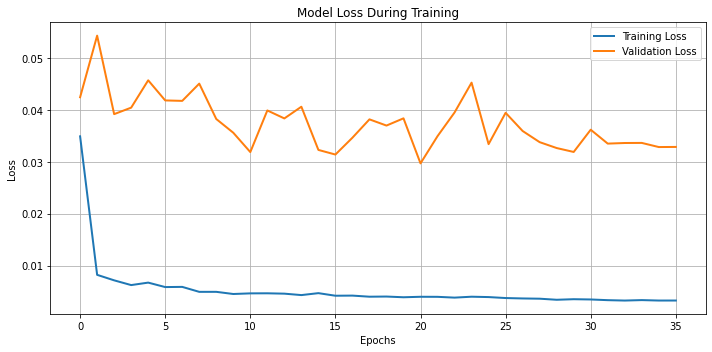

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


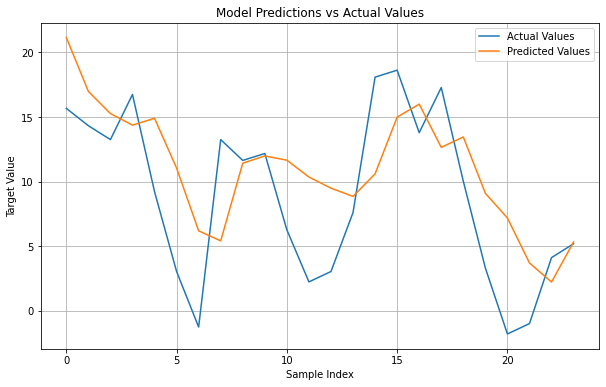

Mean Absolute Error: 4.42
Mean Squared Error: 26.90
Root Mean Squared Error: 5.19
R² Score: 0.34


In [15]:
model = load_model("best_model_3.keras")
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.title("Model Predictions vs Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid()
plt.show()

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
